# Example Test OtrisymNMF VS DCBM on karate club network


In [1]:
import pysbm
import networkx as nx
import matplotlib.pylab as pl
from Utils import DC_BM
import OtrisymNMF
import numpy as np
from sklearn.metrics import normalized_mutual_info_score as NMI

The Zachary's Karate Club network is a commonly used benchmark for evaluating community detection algorithms. The network represents the social interactions among the 34 members of a karate club at an American university. Following an internal conflict, the club split into two distinct factions.


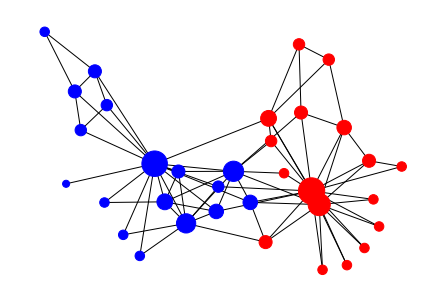

In [2]:
# Reading and displaying the graph
graph = nx.karate_club_graph()
club_labels = {node: 1 if graph.nodes[node]['club'] == 'Mr. Hi' else 0 for node in graph.nodes}
club_vector = np.array([club_labels[node] for node in sorted(graph.nodes)])
position = nx.spring_layout(graph,seed=23)
node_sizes = [10+graph.degree(node) * 40 for node in graph]  # Facteur d'échelle pour bien voir les tailles
nx.draw(graph, position, node_color=['r' if club_vector[node] == 0 else 'b' for node in graph],node_size=node_sizes)
pl.show()

Let's use the OtrisymNMF factorization of the adjacency matrix of graph X with r = 2 to detect the 2 communities in the network.
- v is a vector that gives the community index for each node.
- w indicates the importance of a node within its community.
- S describes interactions between the r communities.

In [3]:
X = nx.adjacency_matrix(graph, nodelist=sorted(graph.nodes))
w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X, 2,numTrials=10,verbosity=0)

To compare the partition found by OtrisymNMF with the ground truth partition, we calculate the NMI. We also display the partition obtained by OtrisymNMF. It can be observed that only one node was misclassified—the same node that is misclassified by other community detection methods.

NMI score: 0.8371694628777809


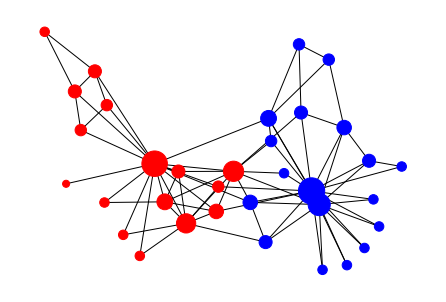

In [4]:
print("NMI score:",NMI(club_vector,v))
nx.draw(graph, position, node_color=['r' if v[node] == 1 else 'b' for node in graph],node_size=node_sizes)
pl.show()

Now, let's compare it with the degree-corrected model (DCBM) of Karrer and Newman.

NMI score: 0.0
The node misclassified additionally compared to OtrisymNMF: [6, 7, 10, 11, 12, 13, 17, 19, 21, 23, 24, 26, 30, 31, 32, 33]


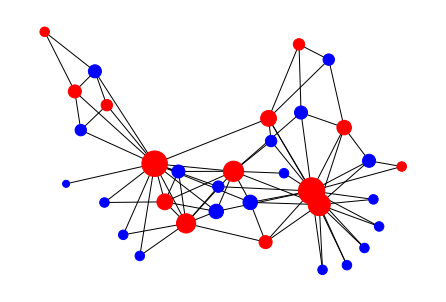

In [5]:
DCBM_partition=DC_BM(graph,2,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.KerninghanLinInference, numTrials=10)
print("NMI score:",NMI(club_vector,DCBM_partition))
print("The node misclassified additionally compared to OtrisymNMF:",[i for i,value in enumerate(v != DCBM_partition) if value])
nx.draw(graph, position, node_color=['r' if DCBM_partition[node] == 1 else 'b' for node in graph],node_size=node_sizes)
pl.show()

We observe that there is one additional misclassified node compared to OtrisymNMF. To verify that this is not due to the inference method, let's calculate the (log) probability of the model for this partition and check that it is indeed higher than that for the ground truth partition and the one found by OtrisymNMF.

In [6]:
degree_corrected_partition = pysbm.NxPartition(
                graph=graph,
                number_of_blocks=2,
                representation={node:DCBM_partition [i] for i, node in enumerate(sorted(graph.nodes))})
logprob = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False).calculate(degree_corrected_partition)
print(f"Log probability of DCBM for the partition just found by DCBM : {logprob:.4f}")
partition_OtrisymNMF = pysbm.NxPartition(
                graph=graph,
                number_of_blocks=2,
                representation={node:v [i] for i, node in enumerate(sorted(graph.nodes))})
logprob2 = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False).calculate(partition_OtrisymNMF)
print(f"Log probability of DCBM for the partition with just one node misclassified : {logprob2:.4f}")
partition_real = pysbm.NxPartition(
                graph=graph,
                number_of_blocks=2,
                representation={node:club_vector [i] for i, node in enumerate(sorted(graph.nodes))})
logprob2 = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False).calculate(partition_real)
print(f"Log probability of DCBM for the real partition : {logprob2:.4f}")




Log probability of DCBM for the partition just found by DCBM : -752.8516
Log probability of DCBM for the partition with just one node misclassified : -739.4321
Log probability of DCBM for the real partition : -743.2071


Indeed, the less accurate partition found by DCBM has a slightly higher probability and is the most probable partition of the model, while OtrisymNMF gives the partition found by community detection algorithms. This difference can be explained by the fact that DCBM uses a Poisson distribution. Since the Karate Club graph is quite dense, this leads to errors because the probability of having an edge is no longer well approximated by the Poisson distribution, which allows for more than one edge.

The node 9 is connected with [ 2 33]


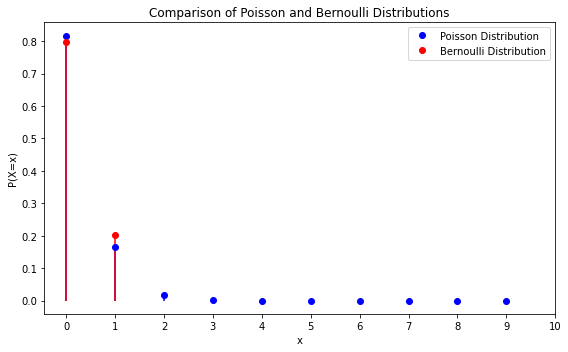

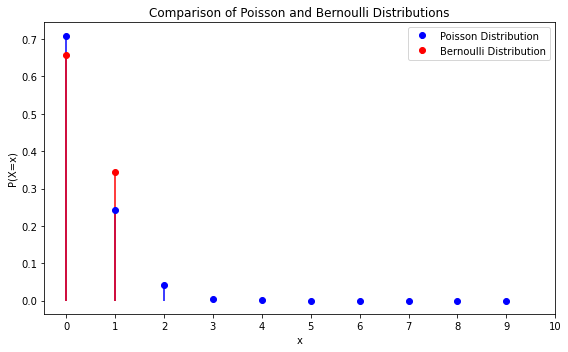

In [7]:
from scipy.sparse import find
import matplotlib.pyplot as plt
from scipy.stats import poisson, bernoulli
print("The node 9 is connected with",np.nonzero(X[:,9])[0])

# Computing of the parameter of the DCBM to model the edge between 9 and 2 and 9 and 33
omega= np.zeros((2, 2))
row, col, values = find(X)

for i in range(len(row)):
    omega[DCBM_partition[row[i]], DCBM_partition[col[i]]] += values[i]
K=sum(omega)
theta_9=np.sum(X[9,:])/K[DCBM_partition[9]]
theta_2=np.sum(X[2,:])/K[DCBM_partition[2]]
theta_33=np.sum(X[33,:])/K[DCBM_partition[33]]

# Comparison of the Poisson and Bernoulli distributions.
for p in [theta_9*omega[DCBM_partition[9],DCBM_partition[2]]*theta_2,theta_9*omega[DCBM_partition[9],DCBM_partition[3]]*theta_33] :
    # Distribution de Poisson
    x_poisson = np.arange(0, 10)  # valeurs possibles pour la distribution de Poisson
    poisson_probs = poisson.pmf(x_poisson, p)  # fonction de masse de probabilité de Poisson

    # Distribution de Bernoulli
    x_bernoulli = [0, 1]  # les deux valeurs possibles pour un essai Bernoulli
    bernoulli_probs = bernoulli.pmf(x_bernoulli, p)  # fonction de masse de probabilité de Bernoulli

    # Plotting both distributions on the same graph
    plt.figure(figsize=(8, 5))

    # Plot Poisson distribution
    plt.stem(x_poisson, poisson_probs, label='Poisson Distribution', basefmt=" ", use_line_collection=True, linefmt='b-', markerfmt='bo')

    # Plot Bernoulli distribution
    plt.stem(x_bernoulli, bernoulli_probs, label='Bernoulli Distribution', basefmt=" ", use_line_collection=True, linefmt='r-', markerfmt='ro')

    # Add labels and title
    plt.title('Comparison of Poisson and Bernoulli Distributions')
    plt.xlabel('x')
    plt.ylabel('P(X=x)')
    plt.xticks(np.arange(0, 11))  # Set x-axis ticks from 0 to 10
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()











